When a random circuit is applied to a product state, and all the qubits are measured, the distribution of the resulting states becomes anti-concentrated. The distribution of the corresponding probabilites themselves can be derived for a Haar random state, and is called the Porter Thomas distribution. Its moments can be used to distinguish the distribution from a uniform distribution and is the basis for quantum supremacy/advantage experiments using random circuit sampling.

Here, we see how the output of a noiseless brick-work random circuit converges to the Porter Thomas distribution. Then we include noise, and examine the effect of noise on the linear cross entropy fidelity.

References  arXiv:1608.00263,  arXiv:2305.04954


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from scipy.stats import unitary_group
import sys
sys.path.append('../src')
from statevector import*

# Porter Thomas Distribution

Distribution of the probabilites of measurement output for a Haar random state is known analytically as the Porter Thomas distribution, such that Prob(p)= (N-1)(1-p)**(N-2).

Let's compare the numerical distribution to the exact form for a small number of qubits.


In [26]:

Nrepeat=1000
Nmeas=20 # number of times a given state is sampled
n=4 #number of qubits

p_arr=[]
for rep in range(Nrepeat):

    psi_ideal=qstate(n,random=True)

    for i in range(Nmeas):
        _,meas=psi_ideal.measure(inplace=False)
        p_arr.append(abs(psi_ideal.arr)**2) #probability of measured Z basis output = meas



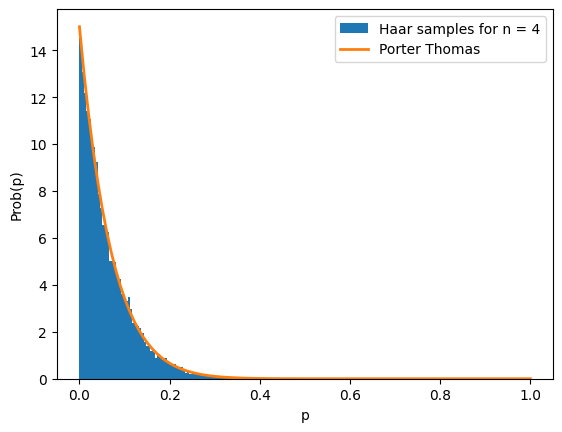

In [27]:
# Plot histogram for the collected probability samples


p_arr=np.ndarray.flatten(np.array(p_arr))
plt.hist(p_arr,bins=100,density=True,label='Haar samples for n = '+str(n))

# exact distribution
def PorterThomas(p,N):
    return (N-1)*((1-p)**(N-2))
x=np.linspace(0,1,100)
p_ideal=[PorterThomas(p,2**n) for p in x]

# plot exact distribution
plt.plot(x,p_ideal,lw=2,label='Porter Thomas')


plt.xlabel("p")
plt.ylabel("Prob(p)")
plt.legend()
plt.show()

# Convergence to Porter Thomas in a random brick-work circuit

Now that we have verified the exact distribution for a Haar random state, let's see how the corresponding distribution for an initial product state evolving under a random brick-work circuit approaches the Porter Thomas distribution.

A convenient way to compare the distribution is to track the moments, and we will do that for the second moment, rescaled so that the new quantity is called the Linear Cross Entropy (XEB) = 2^n < p(x_i)> -1 .

For a uniform distribution of the probabilities, XEB is zero, while for a Haar random state, it is equal to one. When starting with a product state, only the starting bit-string has probability one, implying that XEB= 2**n -1 initially. 

How long does it take XEB to reach 1? Theoretically, we expect convergence in log depth, and let's look specifially for n=12.


In [10]:
# noiseless circuit, with number of layers increasing

n=12 # number of qubits
n_layers=10 # for the brick-work circuit
Nmeas=2000 # number of samples for a given state

# pre-define random layers
brick_layers=[]
for i in range(n_layers):
    layer=[unitary_group.rvs(4) for j  in range(n)]
    brick_layers.append(layer)

#store XEB for each layer
XEB=np.zeros(n_layers)

psi_ideal=qstate(n,random=False)

#evolve without noise
for step in range(n_layers):

    # layer 1 for even numbered qubits
    for m in range(0,psi_ideal.nqubits,2):
        
        twogate=brick_layers[step][m]
        psi_ideal.apply_2gate(gate=twogate,i=m,j=m+1)
        
    # layer 2 for odd numbered qubits
    for m in range(1,psi_ideal.nqubits-1,2):
        
        twogate=brick_layers[step][m]
        psi_ideal.apply_2gate(gate=twogate,i=m,j=m+1)            

    # periodic boundary
    twogate=brick_layers[step][-1]
    psi_ideal.apply_2gate(gate=twogate,i=0,j=psi_ideal.nqubits-1)


    #measure Nmeas times

    for i in range(Nmeas):
        _,meas=psi_ideal.measure(inplace=False)
        XEB[step]+=  abs(psi_ideal.arr[int(meas,2)])**2      

    XEB[step]=(2**psi_ideal.nqubits)*(XEB[step]/Nmeas)-1




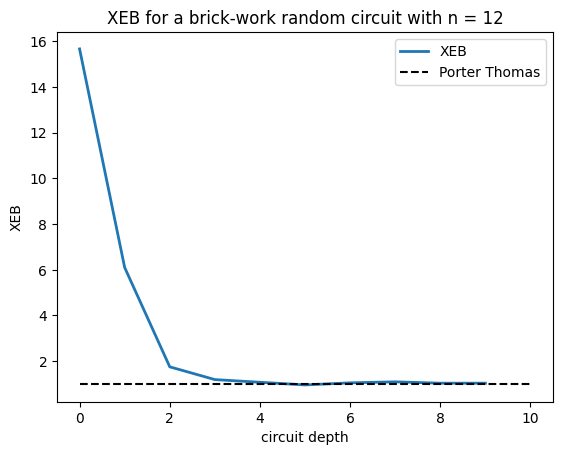

In [16]:
# plot XEB with number of layers

plt.plot(XEB,label="XEB",lw=2)
plt.xlabel("circuit depth")
plt.ylabel("XEB")
plt.hlines([1.0],0,n_layers,linestyle='dashed',color='black',label="Porter Thomas")
plt.legend()
plt.title("XEB for a brick-work random circuit with n = "+ str(n))
plt.show()

# Noisy random circuit sampling

Suppose we have applied sufficient number of layers in our random circuit for the XEB in a noiseless circuit to be one.

How does noise affect the XEB? Consider a depolarizing error channel applied after every two qubit gate. An important point to note is that the XEB is still computed using the noiseless probabilities : a noisy circuit is evolved and then measured, the probability of the measured bit-string for the corresponding noiseless state is used to compute the XEB.

We'll vary the error of the depolarizing channel and compute the XEB, as well as the fidelity, and compare the two quantities.

In [13]:

n=10 # number of qubits

n_layers=10 # fixed number of layers such that noiseless XEB=1

Nrepeat=300 # for the same noise level, repeat

crepeat=10 # number of different circuits

Nmeas = 100 # number of samples for each circuit

p_err=np.linspace(0,0.01,11) # different two qubit depolarizing error rates            

XEB_noisy=np.zeros(len(p_err)) # store XEB for each p_dep in p_err

fidelity_arr=np.zeros(len(p_err),dtype=complex) # fidelity between noiseless and noisy circuit


# different circuit instances
for crep in range(crepeat):

    # initialize with product state
    psi_ideal=qstate(n,random=False)

    # choose an instance of a random brick-work circuit
    brick_layers=[]
    for j in range(n_layers):
        layer=[unitary_group.rvs(4) for j  in range(n)]
        brick_layers.append(layer)
          
    # apply the circuit without any noise
    for step in range(n_layers):
    
        # layer 1 for even numbered qubits        
        for m in range(0,psi_ideal.nqubits,2):
            
            twogate=brick_layers[step][m]
            psi_ideal.apply_2gate(gate=twogate,i=m,j=m+1)
            
        # layer 2 for odd numbered qubits      
        for m in range(1,psi_ideal.nqubits-1,2):
            
            twogate=brick_layers[step][m]
            psi_ideal.apply_2gate(gate=twogate,i=m,j=m+1)            
    
        # periodic boundary
        twogate=brick_layers[step][-1]
        psi_ideal.apply_2gate(gate=twogate,i=0,j=psi_ideal.nqubits-1)


    # for each circuit instance, consider different noise levels
    
    for i,p_dep in enumerate(p_err):
        print("circuit instance = ",crep,", error rate = ",p_dep)

        # repeat noisy Pauli gates to sample from depolarizing error channel
        
        for rep in range(Nrepeat):
            # initialize state again
            
            psi_noisy=qstate(n,random=False)

            # apply brick-work layers with noise
            
            for step in range(n_layers):
            
                # layer 1 for even numbered qubits    
                for m in range(0,psi_noisy.nqubits,2):
                    
                    twogate=brick_layers[step][m]
                    psi_noisy.apply_2gate(gate=twogate,i=m,j=m+1,p2=p_dep)
                    
                # layer 2 for odd numbered qubits
                for m in range(1,psi_noisy.nqubits-1,2):
                    
                    twogate=brick_layers[step][m]
                    psi_noisy.apply_2gate(gate=twogate,i=m,j=m+1,p2=p_dep)            
            
                # periodic boundary
                twogate=brick_layers[step][-1]
                psi_noisy.apply_2gate(gate=twogate,i=0,j=psi_noisy.nqubits-1,p2=p_dep)

            # measure Nmeas times, and add the probability corresponding to the ideal noiseless state and its fidelity
            for j in range(Nmeas):
                _,meas=psi_noisy.measure(inplace=False)
                XEB_noisy[i]+=abs(psi_ideal.arr[int(meas,2)])**2
            fidelity_arr[i]+=psi_ideal.overlap(psi_noisy)

# take averages
XEB_noisy=(2**psi_noisy.nqubits)*(XEB_noisy/Nmeas)/(Nrepeat*crepeat)-1
fidelity_arr=fidelity_arr/(Nrepeat*crepeat)
    



circuit instance =  0 , error rate =  0.0
circuit instance =  0 , error rate =  0.001
circuit instance =  0 , error rate =  0.002
circuit instance =  0 , error rate =  0.003
circuit instance =  0 , error rate =  0.004
circuit instance =  0 , error rate =  0.005
circuit instance =  0 , error rate =  0.006
circuit instance =  0 , error rate =  0.007
circuit instance =  0 , error rate =  0.008
circuit instance =  0 , error rate =  0.009000000000000001
circuit instance =  0 , error rate =  0.01
circuit instance =  1 , error rate =  0.0
circuit instance =  1 , error rate =  0.001
circuit instance =  1 , error rate =  0.002
circuit instance =  1 , error rate =  0.003
circuit instance =  1 , error rate =  0.004
circuit instance =  1 , error rate =  0.005
circuit instance =  1 , error rate =  0.006
circuit instance =  1 , error rate =  0.007
circuit instance =  1 , error rate =  0.008
circuit instance =  1 , error rate =  0.009000000000000001
circuit instance =  1 , error rate =  0.01
circuit 

Let's plot the noisy XEB and the fidelity in the same plot

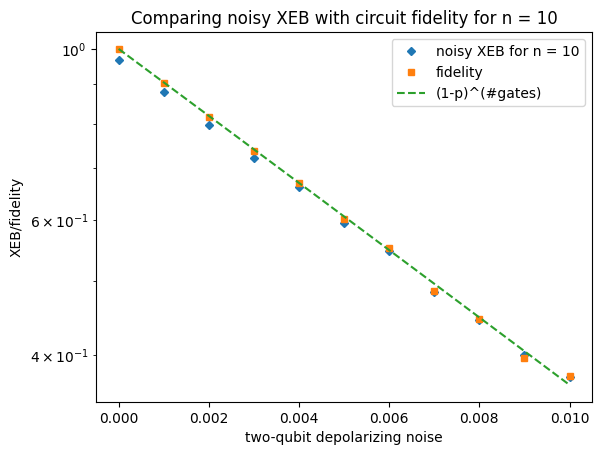

In [14]:

plt.plot(p_err,XEB_noisy,'D',markersize=4,label="noisy XEB for n = "+ str(n))

plt.plot(p_err,fidelity_arr.real,'s',markersize=4,label="fidelity")

# plotting a crude fidelity estimator = (1-p)^{n_gates}
x=np.linspace(0,0.01,100)
y=[(1-p)**(n_layers*n) for p in x]

plt.plot(x,y,'--',label= "(1-p)^(#gates)")

plt.xlabel("two-qubit depolarizing noise")
plt.ylabel("XEB/fidelity")
plt.yscale('log')
plt.title("Comparing noisy XEB with circuit fidelity for n = " +str(n))
plt.legend()
plt.show()


The fidelity appears to be very similar to the noisy XEB, thus linear XEB can often be used as a benchmarking method! 